In [2]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_density, geom_line, geom_point, 
    geom_violin, facet_grid, labs, theme, facet_wrap,
)

# for rl training
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# the rl environment
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv

# helper that paralelizes episode simulations for evaluation purposes (agent -> reward)
from rl4greencrab import evaluate_agent

# helper that creates a single episode simulation keeping track of many variables
# of the internal env state
from rl4greencrab import simulator

ModuleNotFoundError: No module named 'rl4greencrab'

In [8]:
config = {"init_n_adult": 0}
gmonth = greenCrabMonthEnv()
vec_env = make_vec_env(greenCrabMonthEnv, n_envs=12)

In [9]:
model = PPO("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("ppo_gcse_month")

Output()

In [3]:
evalEnv = greenCrabMonthEnv()
ppoAgent = PPO.load("ppo_gcse_month")
mean_rew, std_rew = evaluate_policy(ppoAgent, evalEnv)
print(f"PPO reward = {mean_rew:.5f} +/- {std_rew:.5f}")

/opt/conda/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.


PPO reward = -22.97501 +/- 6.42140


In [ ]:
td3Agent = TD3.load("TD3_gcme")
mean_rew, std_rew = evaluate_policy(td3Agent, evalEnv)
print(f"TD3 reward = {mean_rew:.5f} +/- {std_rew:.5f}")

In [5]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,0.0,0.0,0.056337,0.057689,0.000000,0
1,1,0.0,0.0,0.056337,0.057689,-0.262198,0
2,2,0.0,0.0,0.056337,0.057689,-0.523036,0
3,3,0.0,0.0,0.056337,0.057689,-0.781887,0
4,4,1.0,0.0,0.055197,0.053569,-1.037871,0


<Axes: xlabel='t'>

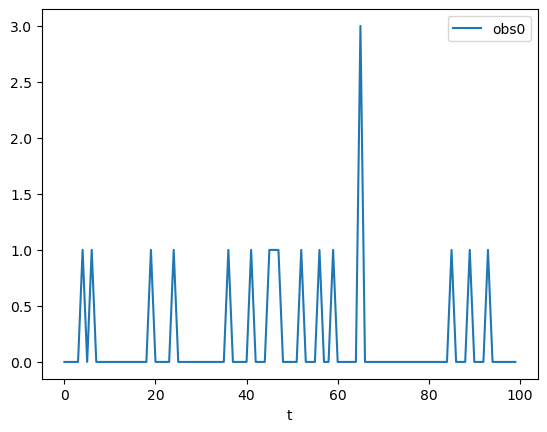

In [6]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])